In [1]:
import os, scipy, sys, pandas as pd, numpy as np, datetime, seaborn as sns
from util import *

In [2]:
# input input and output directories
input_dir = input('Enter the path to the folder containing the input files: ')
output_dir = input('Enter the path to the folder containing the output files: ')

Enter the path to the folder containing the input files: /Users/mikodai/Desktop/Papouin lab/Projects/Calcium STARDUST/STARDUST pipeline/input files
Enter the path to the folder containing the output files: /Users/mikodai/Desktop/Papouin lab/Projects/Calcium STARDUST/STARDUST pipeline/output files


In [3]:
# input metadata related to the experiment
keyword = input('Enter the common keyword in input file (csv, ROA mask and cell mask) names: ')
experiment_date = input('Enter the experiment date (e.g. 2023-11-06): ')
mouse_ID = input('Enter the mouse ID: ')
slice_number = int(input('Enter the slice number: '))
drug_frame = float(input('Enter the frame number of drug application (enter NA if no drug was applied): '))
frame_rate = int(input("Enter the frame rate (in Hz) of the recording (e.g. 20): "))
output_filename = input('Enter the output file name: ') + '.xlsx'
output_path = os.path.join(output_dir, output_filename)

Enter the common keyword in input file (csv, ROA mask and cell mask) names: pnu
Enter the experiment date (e.g. 2023-11-06): 2023-02-14
Enter the mouse ID: 1234
Enter the slice number: 1
Enter the frame number of drug application (enter NA if no drug was applied): 120
Enter the frame rate (in Hz) of the recording (e.g. 20): 1
Enter the output file name: pnu_test


In [4]:
# find the input files
csv_path, ROA_mask_path, cell_mask_path = find_files(input_dir, keyword)

Found the following files: 

CSV file:  /Users/mikodai/Desktop/Papouin lab/Projects/Calcium STARDUST/STARDUST pipeline/input files/02142023_slice1_ttx_pnu.csv
ROA mask:  /Users/mikodai/Desktop/Papouin lab/Projects/Calcium STARDUST/STARDUST pipeline/input files/02142023_slice1_ttx_pnu_roa_mask.tif
Cell mask:  /Users/mikodai/Desktop/Papouin lab/Projects/Calcium STARDUST/STARDUST pipeline/input files/02142023_slice1_ttx_pnu_cell_mask.tif


In [5]:
ROA_map_labeled, ROA_map_count, cell_map_labeled, cell_count = read_masks(ROA_mask_path, cell_mask_path)

ROA mask contains 452 ROAs
Cell mask contains 24 cells


In [6]:
filtered_traces = raw_to_filtered(csv_path)

Reading in file:  /Users/mikodai/Desktop/Papouin lab/Projects/Calcium STARDUST/STARDUST pipeline/input files/02142023_slice1_ttx_pnu.csv 


The current file contains: 
Number of ROA:  452
Number of frames:  611

Applying a lowpass Butterworth filter with a 4 th order filter at the cutoff of 0.4 Hz


In [7]:
ROA_count, frame_count = check_traces(filtered_traces)

The current file contains: 
Number of ROA:  452
Number of frames:  611


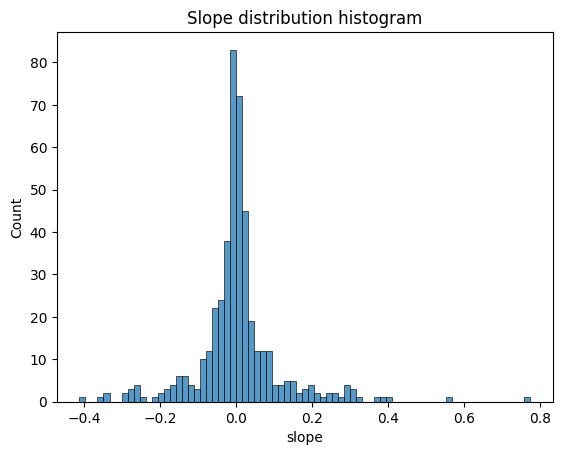

In [8]:
corrected_traces, reg = correct_shift(filtered_traces)

Enter the slope cutoff (absolute value) for visualizing correction:0.3


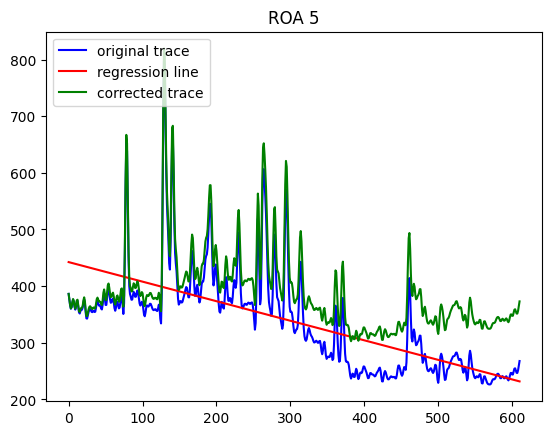

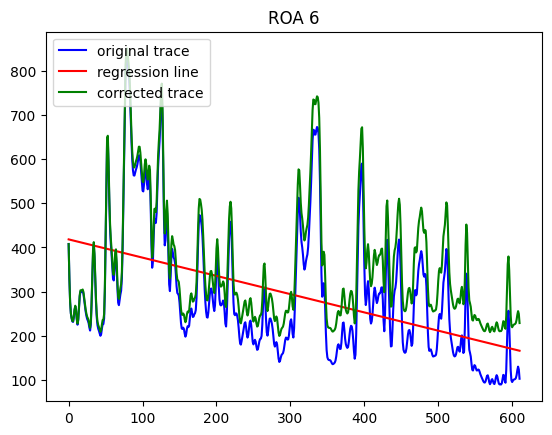

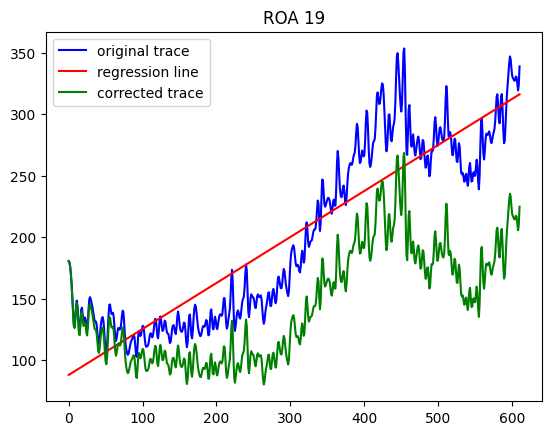

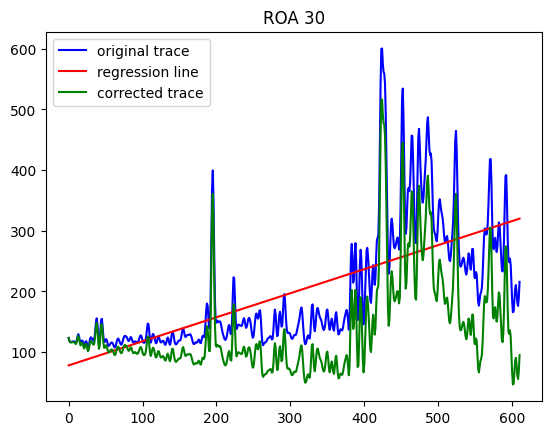

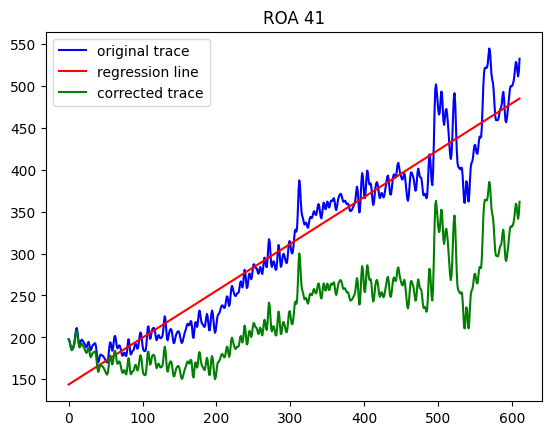

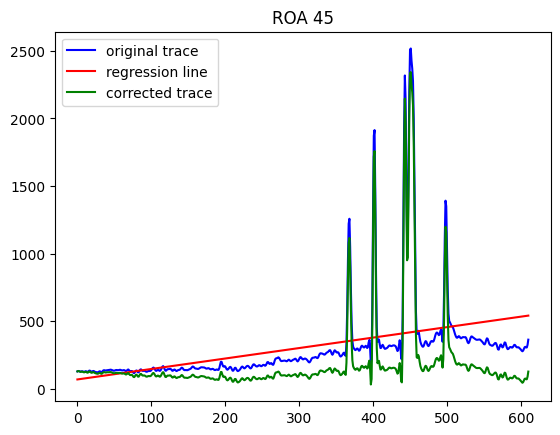

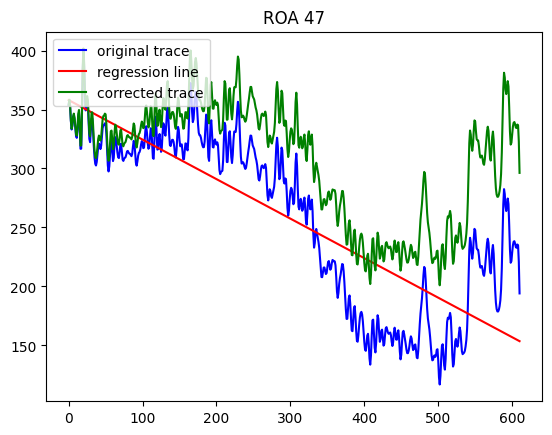

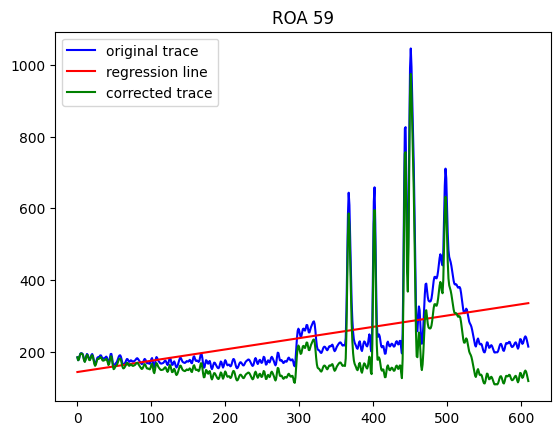

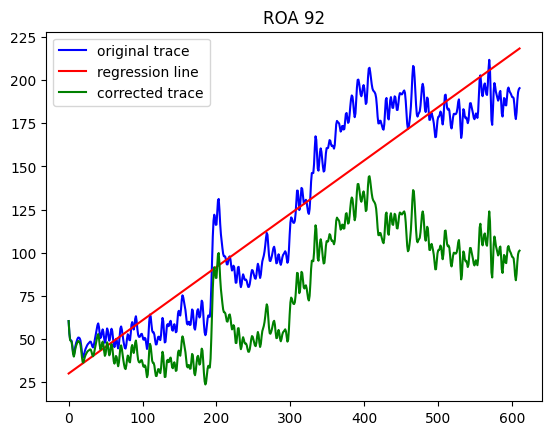

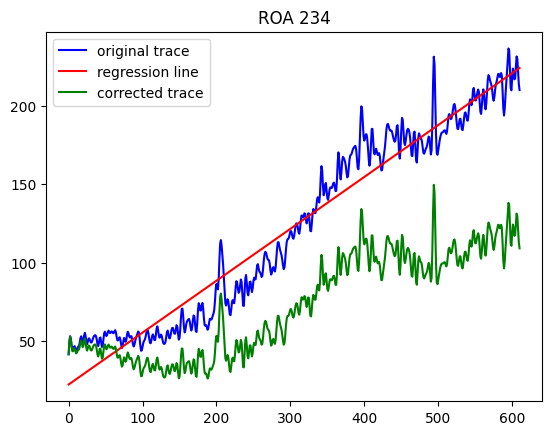

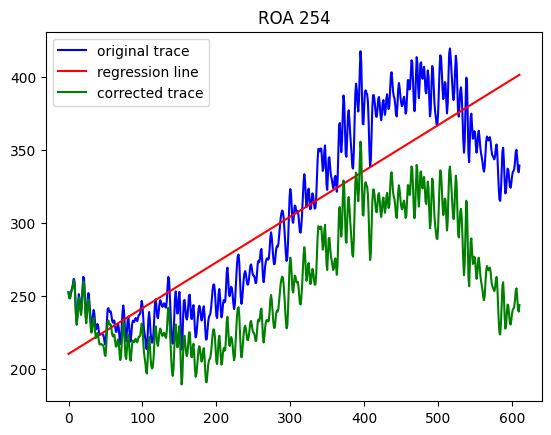

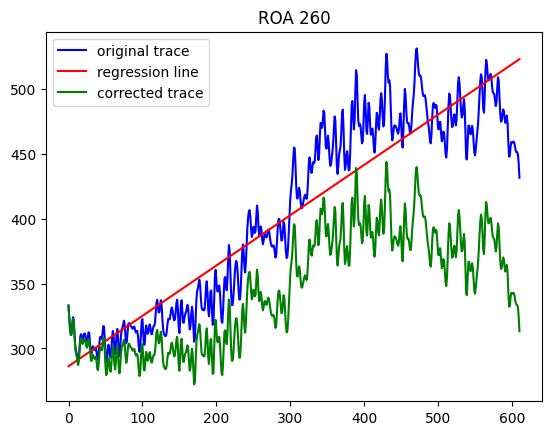

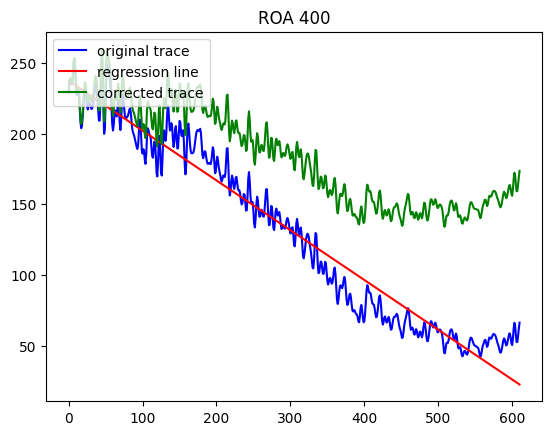

In [9]:
# optional visualization point
check_correction(filtered_traces, corrected_traces, reg)

In [10]:
dff_traces, baselines, thresholds, signal_frames, signal_boundaries = iterative_baseline(corrected_traces)

Enter the number of iterations for signal detection (e.g. 3): 5

Processing round 1 of signal detection...
ROAs with signal:  372
ROAs without signal:  80

Processing round 2 of signal detection...
ROAs with signal:  369
ROAs without signal:  83

Processing round 3 of signal detection...
ROAs with signal:  371
ROAs without signal:  81

Processing round 4 of signal detection...
ROAs with signal:  369
ROAs without signal:  83

Processing round 5 of signal detection...
ROAs with signal:  371
ROAs without signal:  81



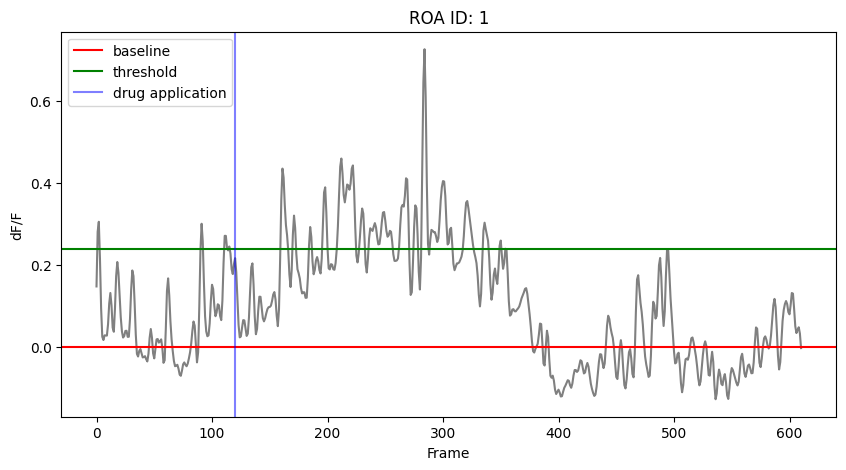

In [19]:
# optional: visualize specific trace
inspect_trace(1, dff_traces, baselines, thresholds= thresholds)

In [20]:
# analyze signals and output signal_stats
signal_stats = analyze_signal(dff_traces,signal_frames, signal_boundaries, frame_rate, drug_frame)

In [21]:
signal_stats.head()

,ROA_ID,signal_start_index,signal_end_index,peak_index,peak_time,AUC,amplitude,signal_to_noise,rise_time,decay_time,half_width,duration,inter_event_interval,Drug
0,1,88,378,284,284.0,63.438571,0.727299,2.380802,125.790442,90.909620,0.358157,290.0,NaN,Before
1,2,461,490,470,470.0,11.932674,0.932487,0.983433,6.699639,18.602427,0.458836,29.0,NaN,After
2,2,579,593,583,583.0,7.304733,1.747125,1.842577,2.473212,2.974016,0.851372,14.0,89.0,After
3,3,58,114,73,73.0,14.874257,0.479741,1.061624,12.224616,35.917532,0.232101,56.0,NaN,Before
4,3,142,209,194,194.0,59.758404,4.400532,9.737990,3.391808,8.652543,2.192399,67.0,28.0,After


In [22]:
# add corresponding cell ID to the signal stats
df_ROA_cell = align_ROA_cell(ROA_map_labeled, cell_map_labeled, ROA_map_count)
signal_stats = pd.merge(df_ROA_cell, signal_stats, on = 'ROA_ID', how = 'right')

In [23]:
signal_stats

,ROA_ID,cell_ID,signal_start_index,signal_end_index,peak_index,peak_time,AUC,amplitude,signal_to_noise,rise_time,decay_time,half_width,duration,inter_event_interval,Drug
0,1,1,88,378,284,284.0,63.438571,0.727299,2.380802,125.790442,90.909620,0.358157,290.0,NaN,Before
1,2,1,461,490,470,470.0,11.932674,0.932487,0.983433,6.699639,18.602427,0.458836,29.0,NaN,After
2,2,1,579,593,583,583.0,7.304733,1.747125,1.842577,2.473212,2.974016,0.851372,14.0,89.0,After
3,3,1,58,114,73,73.0,14.874257,0.479741,1.061624,12.224616,35.917532,0.232101,56.0,NaN,Before
4,3,1,142,209,194,194.0,59.758404,4.400532,9.737990,3.391808,8.652543,2.192399,67.0,28.0,After
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,447,24,59,73,64,64.0,2.834791,0.546853,1.731300,2.969003,6.715769,0.262214,14.0,NaN,Before
2640,447,24,274,285,278,278.0,1.920520,0.542623,1.717908,1.955664,2.372157,0.269235,11.0,201.0,After
2641,447,24,352,359,356,356.0,1.303802,0.395047,1.250690,2.714296,1.994727,0.190651,7.0,67.0,After
2642,447,24,434,443,439,439.0,2.726491,0.546905,1.731464,2.314992,2.863583,0.268329,9.0,75.0,After


In [24]:
ROA_based, df_ROA_cell = ROA_analysis(signal_stats, df_ROA_cell)

In [25]:
ROA_based

,ROA_ID,cell_ID,ROA_type,Drug,signal_start_index,signal_end_index,peak_index,peak_time,AUC,amplitude,signal_to_noise,rise_time,decay_time,half_width,duration,inter_event_interval,signal_count
0,1,1,off,Before,88.000000,378.000000,284.000000,284.000000,63.438571,0.727299,2.380802,125.790442,90.909620,0.358157,290.000000,NaN,1.0
1,2,1,on,After,520.000000,541.500000,526.500000,526.500000,9.618703,1.339806,1.413005,4.586426,10.788221,0.655104,21.500000,89.000000,2.0
2,3,1,stable,After,401.000000,430.285714,421.428571,421.428571,13.499275,1.353316,2.994769,3.099562,5.122405,0.665392,29.285714,41.285714,7.0
3,3,1,stable,Before,58.000000,114.000000,73.000000,73.000000,14.874257,0.479741,1.061624,12.224616,35.917532,0.232101,56.000000,NaN,1.0
4,4,4,stable,After,375.888889,407.000000,387.333333,387.333333,13.256259,1.429702,6.206859,5.830351,7.419376,0.705656,31.111111,20.444444,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,448,24,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
694,449,24,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
695,450,24,inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
696,451,24,off,Before,110.000000,339.000000,184.000000,184.000000,39.245981,0.887561,2.629301,27.334943,38.541936,0.442760,229.000000,NaN,1.0


In [26]:
df_ROA_cell

,ROA_ID,cell_ID,ROA_type
0,1,1,off
1,2,1,on
2,3,1,stable
3,4,4,stable
4,5,4,stable
...,...,...,...
447,448,24,inactive
448,449,24,inactive
449,450,24,inactive
450,451,24,off


In [28]:
df_ROA_cell.groupby('ROA_type').count()

,ROA_ID,cell_ID
ROA_type,,
inactive,81,81
off,18,18
on,107,107
stable,246,246
